<font color=darkblue> 

## Описание задачи
___
    
### Интернет-магазин «Стримчик», продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

## Описание данных

- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы долларов)
- EU_sales — продажи в Европе (миллионы долларов)
- JP_sales — продажи в Японии (миллионы долларов)
- Other_sales — продажи в других странах (миллионы долларов)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

__Вызываю библиотеки__

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats as st
from matplotlib.gridspec import GridSpec

<font color=blue> 
# Знакомство с данными

__Открываю датасет__

In [2]:
games = pd.read_csv('/datasets/games.csv')

In [3]:
games

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


__Проверю типы__

In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


__Подробно оценю пропуски__

In [5]:
games_na = pd.DataFrame(games.isna().sum())
games_na['percent'] = games_na[0] * 100 / len(games)
(games_na[(games_na['percent'] > 0)]).head(20)

,0,percent
Name,2,0.011965
Year_of_Release,269,1.609333
Genre,2,0.011965
Critic_Score,8578,51.319174
User_Score,6701,40.089740
Rating,6766,40.478612


 __Посмотрю есть ли явные зависимости (продажи, рейтинги) в пропусках по году релиза__

In [6]:
games['Year_of_Release'] = games['Year_of_Release'].fillna(value = 0)
games.query('Year_of_Release == 0').head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
183,Madden NFL 2004,PS2,0.0,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,0.0,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,0.0,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,0.0,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,0.0,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN


## Вывод

- Регистр столбцов вразнобой, необходимо привести к нижнему.
- В столбце 'name' наверняка дублирование, могут быть мультиплатформенные игры.
- У некоторых игр отсутствуют рейтинги. (Судя по всему старые игры и игры с низкими продажами не имеют рейтингов).
- Пропуски в годах
- Система рейтингов непонятна и с учетом такого количества пропусков не совсем ясно куда ее применить.
- Необходимо заменить формат дат, users score и rating привести к числовому формату.
- По два значения с пропусками в жанрах и наименованиях можно удалить
- Есть корреляция между оценками и продажами в диапозоне от 4,3 до 8,0 - прямая, далее - обратная 


<font color=blue> 
# Подготовка данных

## Что делаю
- Заменю пропуски дат по медиане платформы, потому как платформы живут какое-то время, а большинство игр выходит в пик их популярности
- Заменю формат даты.
- Заменю tbd на NaN
- Определю средний срок жизни платформы
- Приведу столбцы к нижнему регистру.

### Проверю пропуски в годах

In [7]:
games['Year_of_Release'].unique()

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000.,    0., 1995., 1991., 1981., 1987.,
       1980., 1983.])

### Заменю нолевые значения неизвестным

In [8]:
games['Year_of_Release'] = games.Year_of_Release.replace(0, np.nan)

### Соберу фрейм по медиане релизов по платформам и году последнего и первого релиза

In [9]:
platforms_years = games.pivot_table(index = 'Platform', values = 'Year_of_Release', 
                                    aggfunc = ['median', 'max', 'min']).reset_index()
platforms_years.columns = ['Platform','median', 'maxi', 'mini']

### Добавлю соответствующие столбцы в датафрейм

In [10]:
games = games.merge(platforms_years, on = 'Platform', how = 'left')

In [11]:
games['time_of_life'] = games['maxi'] - games['mini']

### Заменю пропуски в столбце годов релиза значениями из медиан по платформам

In [12]:
games['Year_of_Release'] = games['Year_of_Release'].combine_first(games['median'])

### Удалю лишнее

In [13]:
del games['median']

### Привожу наименования столбцов к нижнему регистру

In [14]:
games.columns = games.columns.str.lower()

### Заменю tbd на NAN

In [15]:
games = games.replace('tbd', np.nan)

### Меняю тип даты

In [16]:
games['year_of_release'] = games['year_of_release'].astype(int)
games['user_score'] =  games['user_score'].astype(float)

### Посчитаю суммарные продажи

In [17]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

### Определю примерный срок жизни платформы

In [18]:
print('Ориентировочное время жизни платформы:', games['time_of_life'].median(), 'Лет')

Ориентировочное время жизни платформы: 10.0 Лет


## Вывод

- tbd - значит тоже что и NaN)
- Ориентировочно платформа живет 10 лет, вероятно пиком популярности бкдет середина этого цикла.

<font color=blue> 
# Анализ данных

__Что делаю__
- Построю график игр и выручки по годам.
- Определю как менялись продажи по платформам. Выбериу платформы с наибольшими суммарными продажами и построю распределение по годамб подтвержу торию о 10 летней жизни платформы и пике в середине жизни?
- Определю актуальный период для исследований на 2017 год.
- Определю платформы лидирующие по продажам, растущие или падающие? Выберу несколько потенциально прибыльных платформ.
- Построю график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам. Определю велика ли разница в продажах и  в средних продажах на разных платформах.
- Посмотрю как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройю диаграмму рассеяния и посчитайю корреляцию между отзывами и продажами. 
- Соотнесу выводы с продажами игр на других платформах.
- Построю наглядное распределение игр по возрастной группе.
- Построю диаграммы и определю самые продаваемые жанры, платформы и возрастной ценз для каждого из регионов.
- Определю топ 5 самых продаваемых игр по регионам и их процентное соотношение.

### Построю график количества релизов игр и выручки по годам.

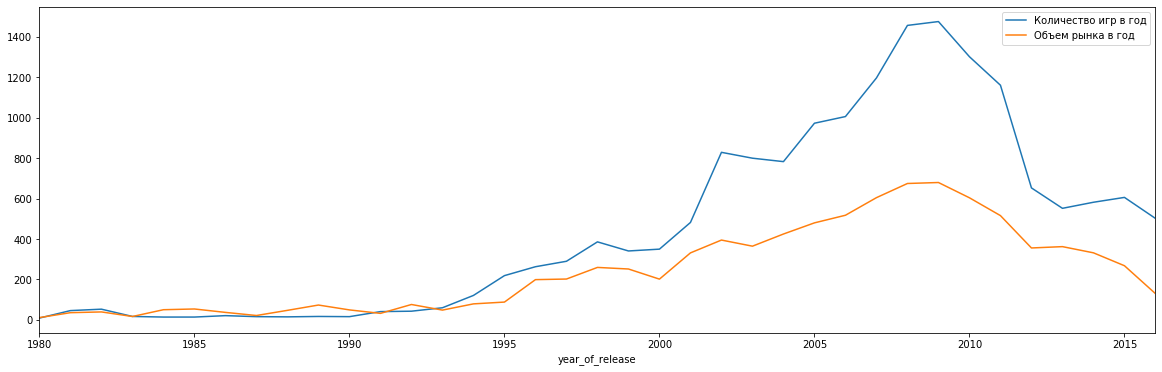

In [19]:
games.groupby('year_of_release')['name'].count().plot(x= 'total_sales',
                                                    figsize = (20,6),
                                                    kind = 'line', label = 'Количество игр в год').legend()
games.groupby('year_of_release')['total_sales'].sum().plot(x= 'total_sales', y='total_sales',
                                                    figsize = (20,6),
                                                    kind = 'line', label = 'Объем рынка в год').legend()
plt.show()

### Построю график по самым продаваемым платформам.

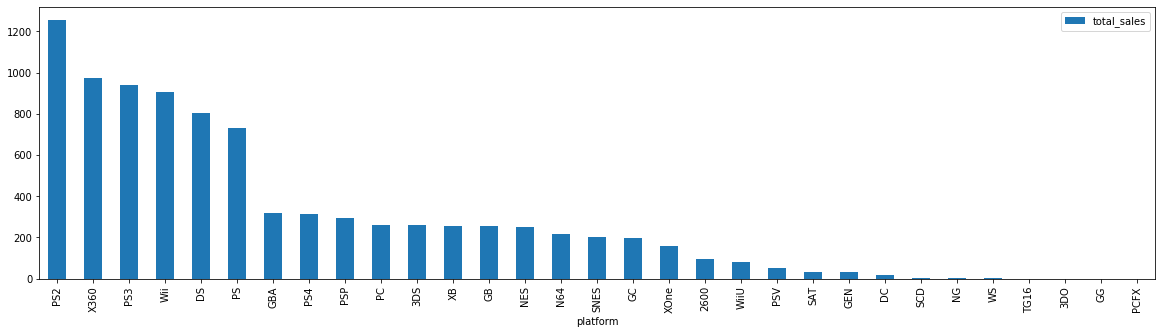

In [20]:
games.pivot_table(index = 'platform'
                    , values = ['total_sales']
                    , aggfunc = 'sum').sort_values('total_sales',
                                                      ascending = False).plot(y = 'total_sales',
                                                                                       figsize = (20,5), kind = 'bar')
plt.show()

### Выведу две таблицы для анализа

- Лучшие по продажам, ушедшие с рынка
- Лучшие по продажам в рынке и новые

### Ушедшие платформы

In [21]:
sort_games = games.pivot_table(index = ['platform', 'mini', 'maxi']
                    , values = ['total_sales']
                    , aggfunc = 'sum').sort_values(['total_sales']
                    , ascending = False).reset_index()
past_sales_analysis = sort_games.query('platform in ("PS2","DS","PS", "GBA", "PSP", "XB", "X360", "Wii")')

In [22]:
year_profit = games.pivot_table(index = ['year_of_release', 'platform'],
                                values = 'total_sales',
                                aggfunc = 'sum').reset_index().sort_values('total_sales',
                                ascending = False).query('year_of_release > 2015')


In [23]:
year_profit

,year_of_release,platform,total_sales
232,2016,PS4,69.25
237,2016,XOne,26.15
229,2016,3DS,15.14
230,2016,PC,5.25
235,2016,WiiU,4.60
233,2016,PSV,4.25
231,2016,PS3,3.60
236,2016,X360,1.52
234,2016,Wii,0.18


In [24]:
present_sales_analysis = games.query('platform in @year_profit.platform and platform not in ("Wii", "X360")')

In [25]:
present_sales_analysis = present_sales_analysis.pivot_table(index = ['platform', 'mini', 'maxi']
                    , values = ['total_sales']
                    , aggfunc = 'sum').sort_values(['total_sales']
                    , ascending = False).reset_index()

In [26]:
present_sales_analysis

,platform,mini,maxi,total_sales
0,PS3,2006.0,2016.0,939.65
1,PS4,2013.0,2016.0,314.14
2,PC,1985.0,2016.0,259.52
3,3DS,2011.0,2016.0,259.00
4,XOne,2013.0,2016.0,159.32
5,WiiU,2012.0,2016.0,82.19
6,PSV,2011.0,2016.0,54.07


### Лучшие по продажам, ушедшие с рынка

In [27]:
past_sales_analysis.head(10)

,platform,mini,maxi,total_sales
0,PS2,2000.0,2011.0,1255.77
1,X360,2005.0,2016.0,971.42
3,Wii,2006.0,2016.0,907.51
4,DS,1985.0,2013.0,806.12
5,PS,1994.0,2003.0,730.86
6,GBA,2000.0,2007.0,317.85
8,PSP,2004.0,2015.0,294.05
11,XB,2000.0,2008.0,257.74


### Лучшие по продажам в рынке.

In [28]:
present_sales_analysis

,platform,mini,maxi,total_sales
0,PS3,2006.0,2016.0,939.65
1,PS4,2013.0,2016.0,314.14
2,PC,1985.0,2016.0,259.52
3,3DS,2011.0,2016.0,259.00
4,XOne,2013.0,2016.0,159.32
5,WiiU,2012.0,2016.0,82.19
6,PSV,2011.0,2016.0,54.07


### Построю графики продаж по платформам, ушедшим с рынка.

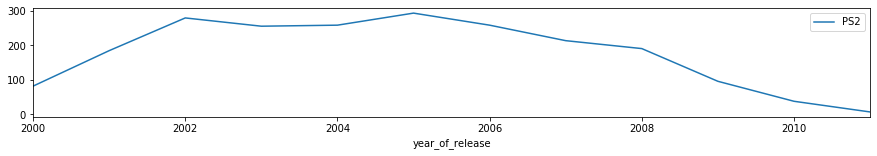

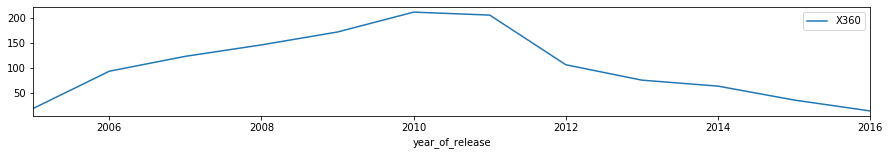

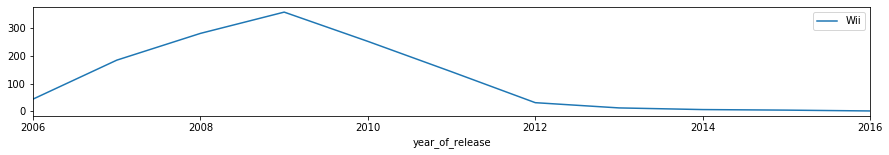

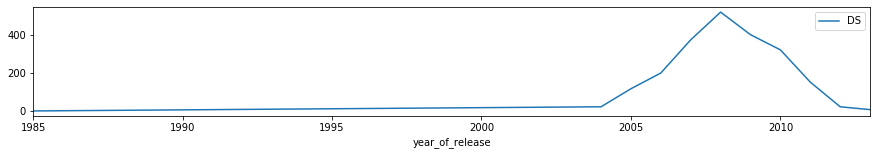

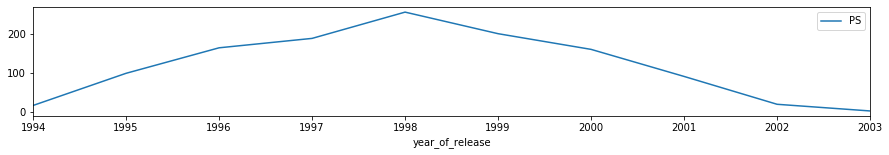

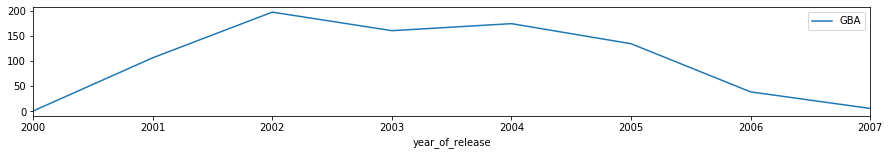

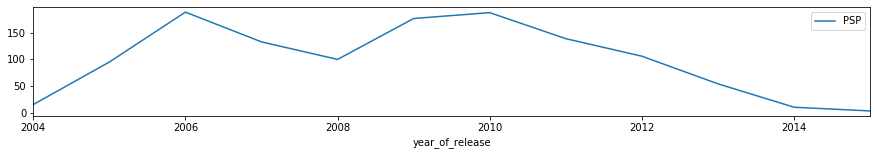

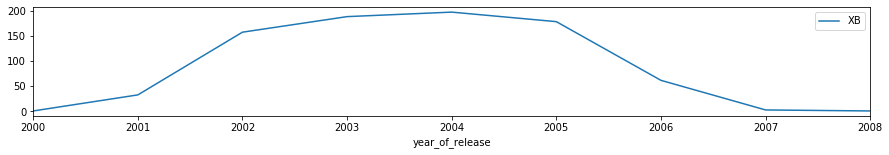

In [29]:
game = past_sales_analysis.platform
for i in game:
    data = games[games['platform'] == i]
    data.pivot_table(index = 'year_of_release'
                    , values = ['total_sales']
                    , aggfunc = 'count').plot(y = 'total_sales', figsize = (15,2), kind = 'line', label = i).legend()

### Построю графики продаж по платформам для игр на рынке.

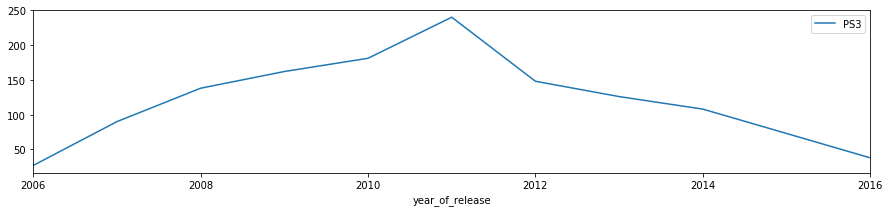

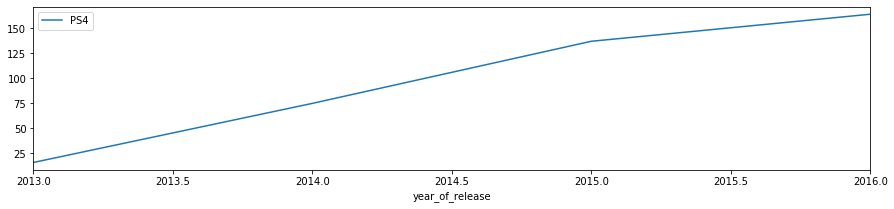

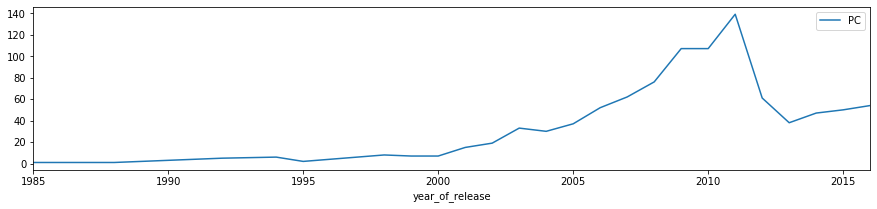

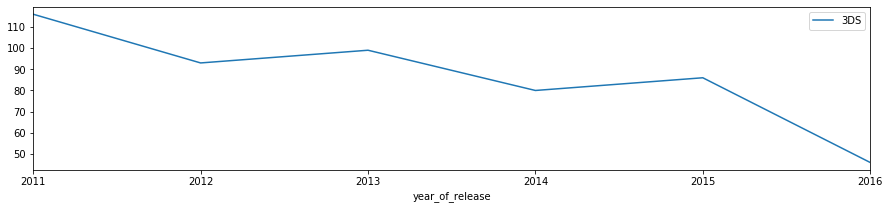

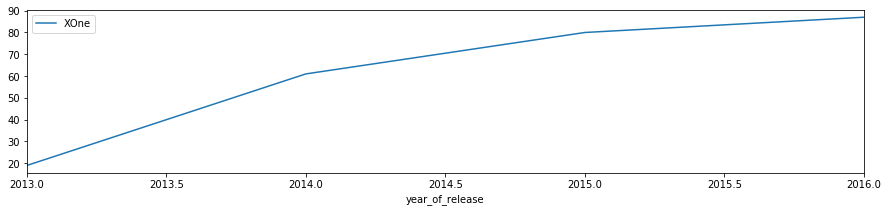

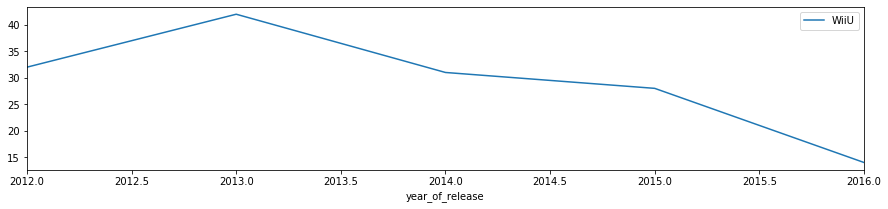

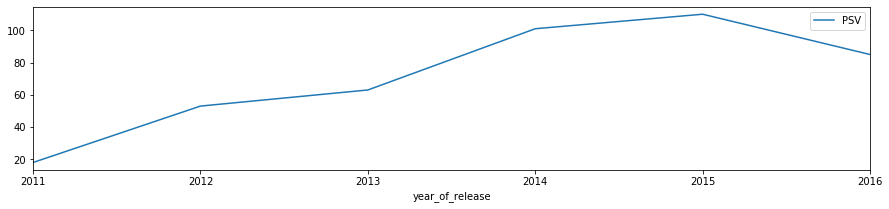

In [30]:
game = present_sales_analysis.platform
for i in game:
    data = games[games['platform'] == i]
    data.pivot_table(index = 'year_of_release'
                    , values = ['total_sales']
                    , aggfunc = 'count').plot(y = 'total_sales', figsize = (15,3), kind = 'line', label = i).legend()


### Числовые значения.

In [31]:
data = games[games['platform'] == 'X360']
data.pivot_table(index = 'year_of_release'
                    , values = ['total_sales']
                    , aggfunc = 'sum')

,total_sales
year_of_release,
2005,8.25
2006,51.62
2007,95.41
2008,135.26
2009,120.29
2010,180.21
2011,143.84
2012,99.74
2013,88.58


## Промежуточный вывод.

- Из графика продаж по платформам, подтвердилась теория о том, что консоли живут в среднем 10 лет и популярны в середине цикла, при этом портативные консоли могут жить как меньше, так и дольше этого срока. Например для X360 в 2005 продажи были на уровне 8,25 млн, к 2010 достигли максимума в 180 млн, а в 2015 упали до практически начальных показателей 2005 года и составили только 11.96 млн. Такая ситуация характерна.

### Выберу существующие на рынке потенциально прибыльные платформы.

In [32]:
#present_sales_analysis = games.query('maxi >= 2016')
present_sales_analysis = games.query('platform in @present_sales_analysis.platform and total_sales < 2').sort_values('total_sales')

### Построю ящик с усами по количеству продаж и диаграмму объема выручки для каждой платформы.

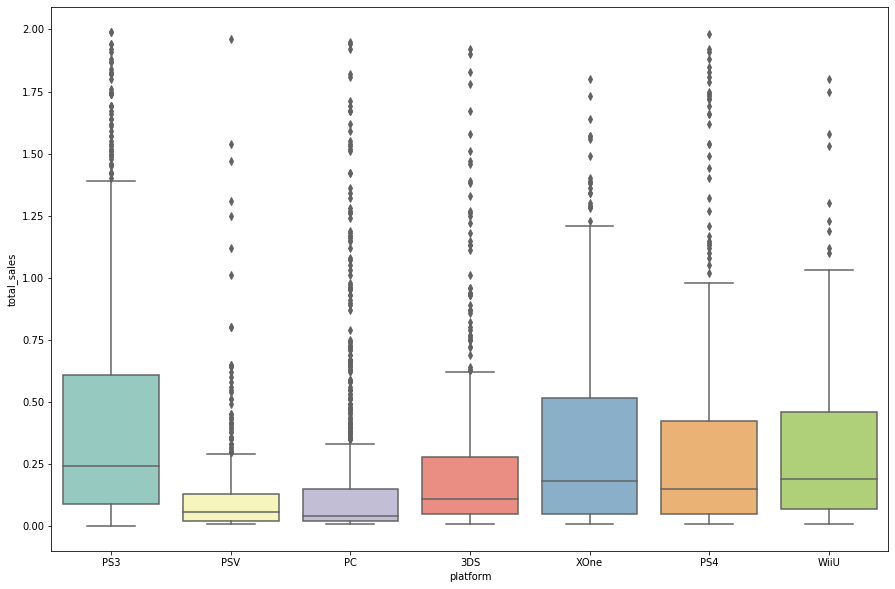

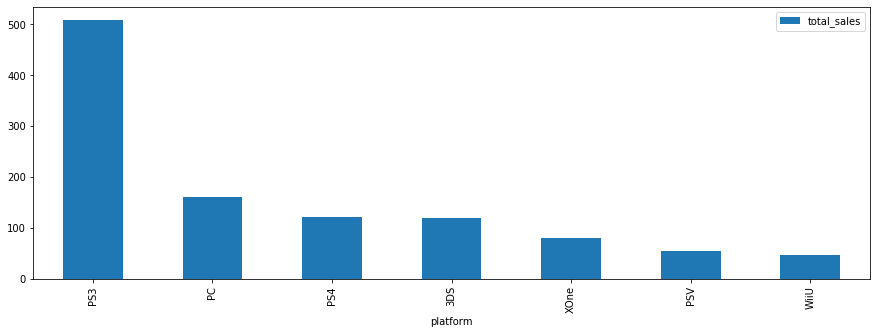

In [33]:
plt.figure(figsize=(15, 10))
sns.boxplot(x="platform", y="total_sales", data=present_sales_analysis, palette='Set3')
present_sales_analysis.pivot_table(index = 'platform'
                    , values = ['total_sales']
                    , aggfunc = 'sum').sort_values('total_sales'
                    , ascending = False).plot(y = 'total_sales'
                    , figsize = (15,5), kind = 'bar')
plt.show()

## Промежуточный вывод.

- Самые высокие продажи как по количеству, так и по выручке отошли. PS3
- XOne при высоких продажах, тем не менее в хвосте по выручке и отстает от PS3 в 5 раз


### Построю график зависимости суммарных продаж от рейтинга критиков для всех платформ.

In [34]:
critics_sales_analysis = present_sales_analysis.query('critic_score > 40 and user_score > 5 and rating != "RP"')

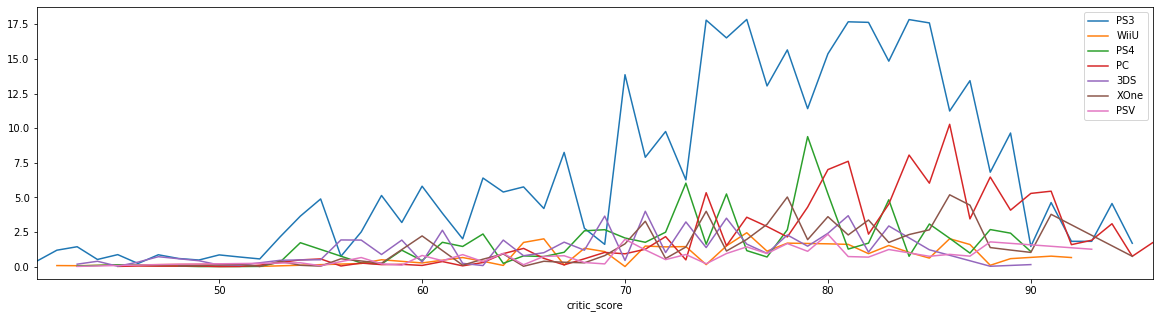

In [35]:
game = ['PS3','WiiU', 'PS4', 'PC', '3DS','XOne', 'PSV']
for i in game:
    data = critics_sales_analysis[critics_sales_analysis['platform'] == i]
    data.groupby('critic_score')['total_sales'].sum().plot(x= 'total_sales', y='critic_score',
                                                    figsize = (20,5),
                                                    kind = 'line', label = i).legend()

### Посчитаю коэфициент корреляции мнения критиков с реальными продажами для каждой платформы.__

In [36]:
game = ['PS3','XOne', 'WiiU', 'PS4', 'PC', '3DS', 'PSV']
for i in game:
    data = present_sales_analysis[present_sales_analysis['platform'] == i]
    value = round(data['total_sales'].corr(data['critic_score']),2)
    print('Коэфициент кореляции критиков',i,'равен:', value)

Коэфициент кореляции критиков PS3 равен: 0.54
Коэфициент кореляции критиков XOne равен: 0.43
Коэфициент кореляции критиков WiiU равен: 0.33
Коэфициент кореляции критиков PS4 равен: 0.29
Коэфициент кореляции критиков PC равен: 0.27
Коэфициент кореляции критиков 3DS равен: 0.26
Коэфициент кореляции критиков PSV равен: 0.13


### Построю график зависимости суммарных продаж от рейтинга пользователей для каждой платформы.

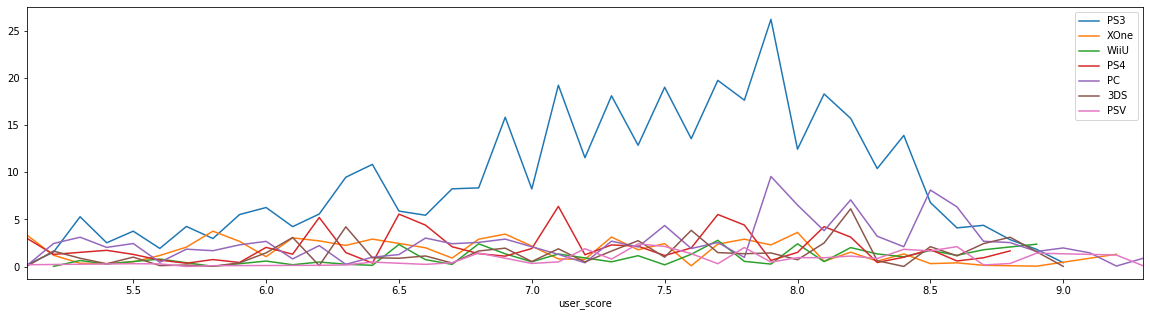

In [37]:
game = ['PS3','XOne', 'WiiU', 'PS4', 'PC', '3DS', 'PSV']
for i in game:
    data = critics_sales_analysis[critics_sales_analysis['platform'] == i]
    data.groupby('user_score')['total_sales'].sum().plot(x= 'total_sales', y='user_score',
                                                    figsize = (20,5),
                                                    kind = 'line', label = i).legend()

### Посчитаю коэфициент корреляции мнения критиков с реальными продажами для каждой платформы.

In [38]:
game = ['WiiU','PS3','XOne',  'PS4', 'PC', '3DS', 'PSV']
for i in game:
    data = present_sales_analysis[present_sales_analysis['platform'] == i]
    value = round(data['total_sales'].corr(data['user_score']),2)
    print('Коэфициент кореляции юзеров',i,'равен:', value)

Коэфициент кореляции юзеров WiiU равен: 0.39
Коэфициент кореляции юзеров PS3 равен: 0.27
Коэфициент кореляции юзеров XOne равен: 0.08
Коэфициент кореляции юзеров PS4 равен: -0.01
Коэфициент кореляции юзеров PC равен: -0.03
Коэфициент кореляции юзеров 3DS равен: 0.18
Коэфициент кореляции юзеров PSV равен: 0.01


### Построю диаграммы рассеяния с линией регрессии для мнения критиков и мнения пользователей.

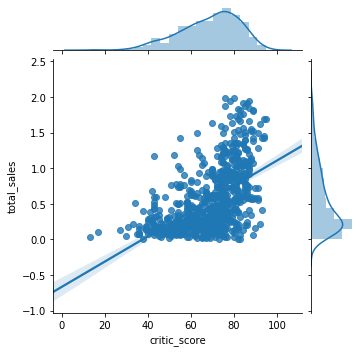

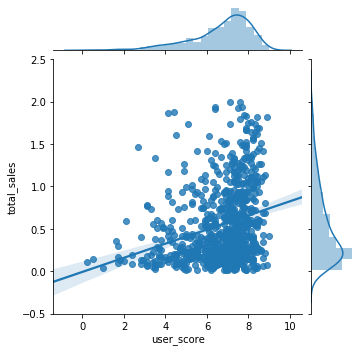

In [39]:
PS3 = present_sales_analysis.query('platform == "PS3"')
the_grid = GridSpec(2, 4)
sns.jointplot(y='total_sales', x='critic_score', height=5, data=PS3, kind='reg') 
sns.jointplot(y='total_sales', x='user_score', data=PS3, height=5, kind='reg')



plt.show()

## Промежуточный вывод.

- Продажи достаточно существенно коррелируют с оценкой критиков, особенно для топовых платформ и в меньшей степени коррелируют с мнением пользователей.


### Построю ящик с усами по количеству продаж и диаграмму объема выручки для каждого жанра.

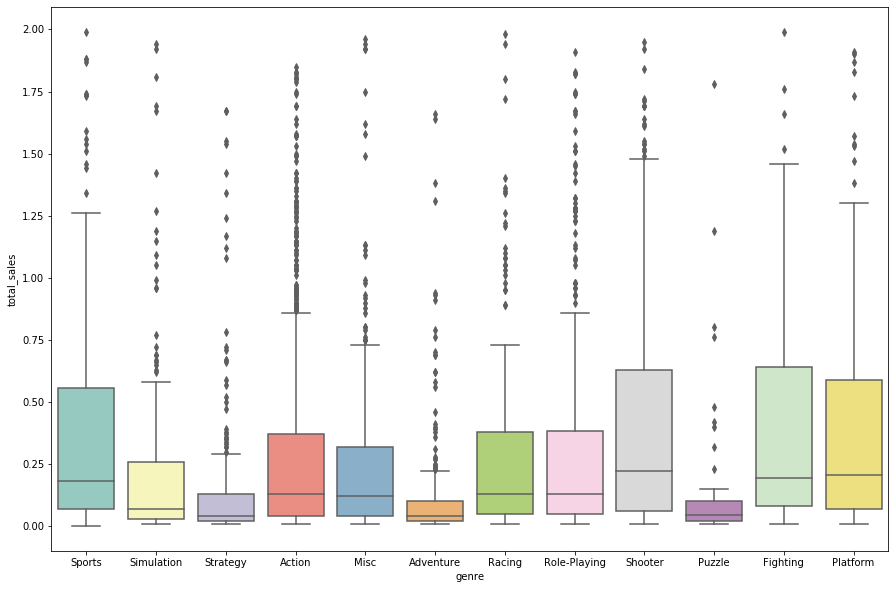

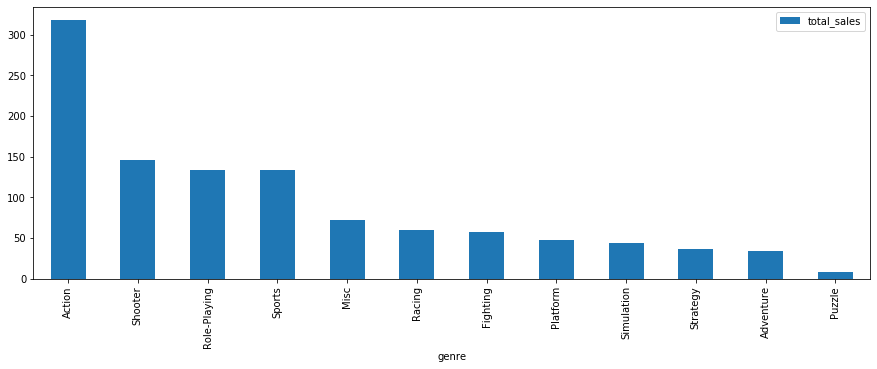

In [40]:
plt.figure(figsize=(15, 10))
sns.boxplot(x="genre", y="total_sales", data=present_sales_analysis, palette='Set3')
present_sales_analysis.pivot_table(index = 'genre'
                    , values = ['total_sales']
                    , aggfunc = 'sum').sort_values('total_sales'
                    , ascending = False).plot(y = 'total_sales'
                    , figsize = (15,5), kind = 'bar')
plt.show()

## Промежуточный вывод.

Игры в жанре Action приносят больше денег, но уступают Sports и Shooter в количестве продаж


### Построю наглядное распределение игр по возрастной группе.

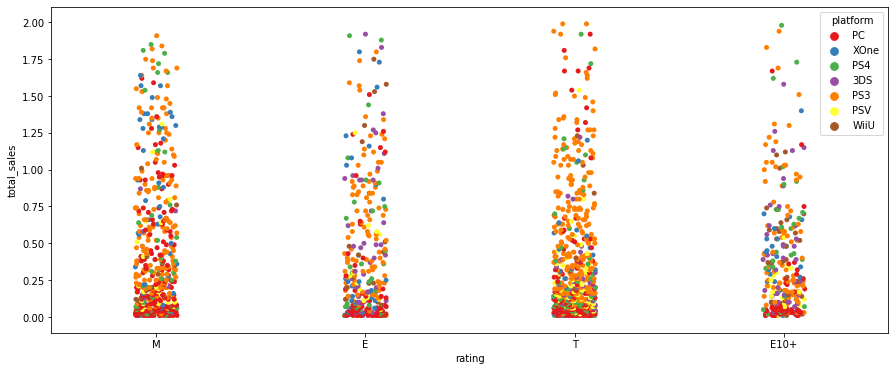

In [41]:
plt.figure(figsize=(15, 6))
sns.stripplot(
    y="total_sales", x="rating",
    data=critics_sales_analysis, jitter=True, hue='platform', palette='Set1')

In [42]:
present_sales_analysis.pivot_table(index = ['rating', 'platform']
                    , values = ['total_sales']
                    , aggfunc = 'sum').sort_values('total_sales', ascending = False).head(10).reset_index()

,rating,platform,total_sales
0,T,PS3,161.44
1,M,PS3,132.89
2,E,PS3,86.03
3,M,PC,62.34
4,E10+,PS3,57.89
5,T,PC,44.73
6,M,XOne,33.77
7,E,3DS,28.03
8,M,PS4,27.47
9,E10+,3DS,24.40


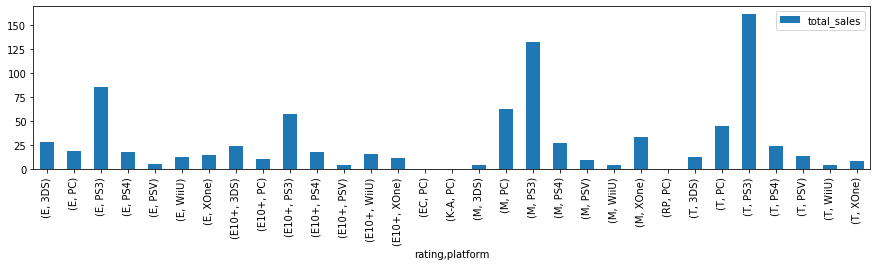

In [43]:
present_sales_analysis.pivot_table(index = ['rating', 'platform']
                    , values = ['total_sales']
                    , aggfunc = 'sum').plot(y = 'total_sales'
                    , figsize = (15,3), kind = 'bar')

## Промежуточный вывод.

Для каждой группы возрастов одинаково высоко привлекательна PS3, но для вторых мест есть разница. Если для взрослых и тинейджеров это PC и PS4, то для детей актуальна 3DS

In [44]:
def donat(depend):
    areas = ['eu_sales','jp_sales','na_sales']
    for i in areas:
        present_sales_analysis.pivot_table(index = depend,
                                   values = [i],
                                   aggfunc = 'sum').sort_values([i], 
                                   ascending = False).head().plot(y = i, 
                                   wedgeprops=dict(width=0.3), shadow=True,
                                   kind = 'pie', rotatelabels=True,
                                   label = i, autopct='%1.0f%%').legend(bbox_to_anchor=(1.1, 1))

### Построю процентное соотношение объемам продаж по платформам для разных регионов.

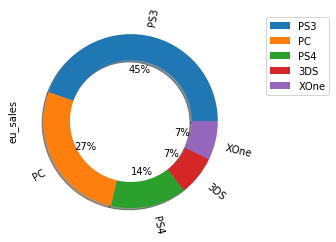

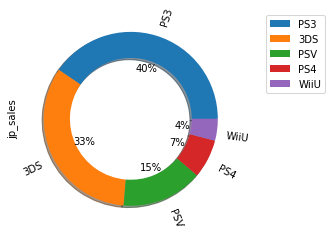

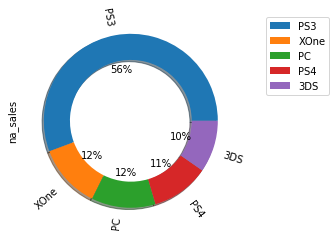

In [45]:
donat('platform')

### Построю процентное соотношение объемам продаж по жанрам для разных регионов.

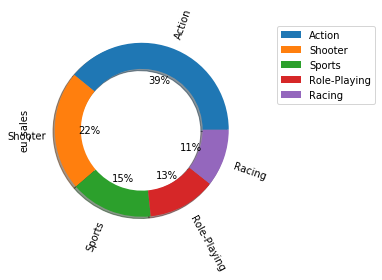

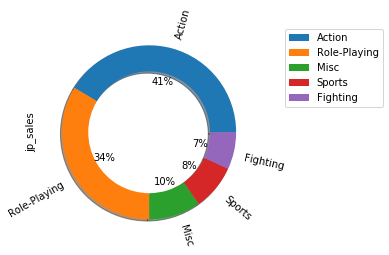

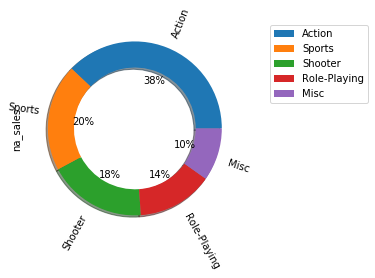

In [46]:
donat('genre')

### Построю процентное соотношение объемам продаж по возрастному рейтингу для разных регионов.

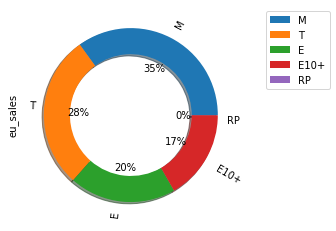

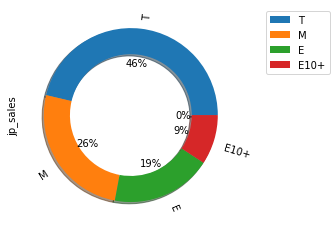

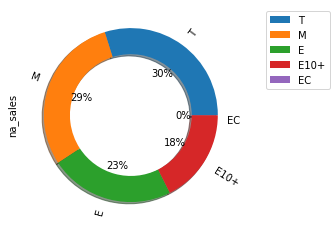

In [47]:
donat('rating')

### Построю процентное соотношение объемам продаж по топ 5 игр.

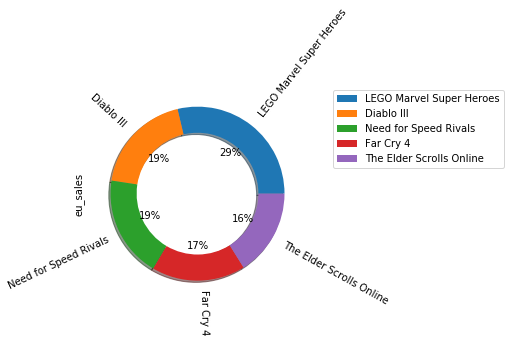

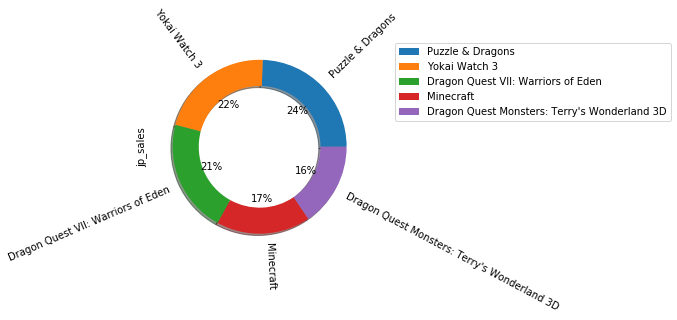

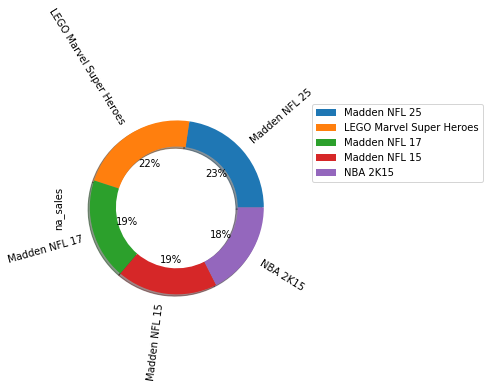

In [48]:
donat('name')

In [49]:
def total_donat(depend):
    areas = ['eu_sales','jp_sales','na_sales']
    for i in areas:
        games.pivot_table(index = depend,
                                   values = [i],
                                   aggfunc = 'sum').sort_values([i], 
                                   ascending = False).head(15).plot(y = i, 
                                   wedgeprops=dict(width=0.3), shadow=True,
                                   kind = 'pie', rotatelabels=True,
                                   label = i, autopct='%1.0f%%').legend(bbox_to_anchor=(1.1, 1))

### Коммерческий успех всех платформ за все время.

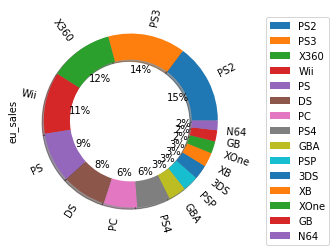

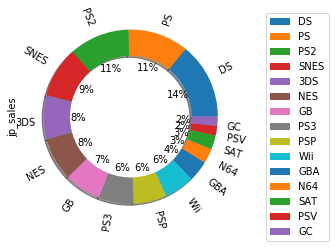

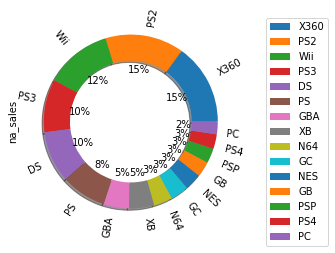

In [57]:
total_donat('platform')

## Вывод

###### - Из построенного графика выручки и количества игр по годам, выяснилось, что количество релизов игр и их продажи непрерывно росли до 2008  года, после чего кривая роста перешла в падение. Вероятно сказался мировой финансовый кризис. Студии обанкротились, а пользователи предпочли не тратить деньги на консоли и соответственно на игры для них.
###### - Из графика продаж по платформам, подтвердилась теория о том, что консоли живут в среднем 10 лет и популярны в середине цикла, при этом портативные консоли могут жить как меньше, так и дольше этого срока. Например для X360 в 2005 продажи были на уровне 8,25 млн, к 2010 достигли максимума в 180 млн, а в 2015 упали до практически начальных показателей 2005 года и составили только 11.96 млн. Такая ситуация характерна.
###### - Глобальные продажи по платформе не всегда означают максимальную прибыль. Например PC показывает меньшие продажи, но большую выручку чем PS4. Хотя в целом высокие продажи и выручка коррелируют. 
###### - Отзывы критиков высоко коррелируют только с топовыми по продажам платформами, например для PS3 коэфициент Пирсона равен 0.54, тогда как для менее популярных платформ он коррелирует значительно меньше (коэфициент для 3DS равен: 0.26).
###### - Отзывы пользователей ведут себя похожим образом, но тут меньше корреляция для популярных платформ (PS3 равен: 0.27), тогда как для менее популярных он может носить и отрицательоное значение (PS4 равен: -0.01)
###### - Возрастные группы тяготеют к платформам: Если все любят PS3 и она на первом месте у всех групп, то для вторых мест для тинейджеров T и взрослых M в топах PS4 а также PC, а для детей (Е10) и E это DS3 со значением 28 и 24.
###### - Предпочтения жанров, платформ и доля покупателей зависит от региона продаж, как видно из дианграмм. Если PS3 везде продается отлично, то для вторых мест в Японии 3DS c 33 процентами, а в Европе пользователи с вероятностью 27 процентов соответственно предпочтут PC, а для Северной Америки с 56% рынка актуальных устройств заняла PS3, остальные делят практически равные доли.
###### - Предпочтительные жанры и даже набор топ 5 игр отличаются для каждого региона. Причем игры отличаюются настолько, что не одна из них не совпадает от региона к региону.
###### - За все времена платформы показывают характерные различия по продажам и для каждого региона они уникальны. Для Европы - это PS2, для Японии - DS, для Америки X360


<font color=blue> 
# Проверка гипотез

__Средние пользовательские рейтинги платформ Xbox One и PC одинаковые__

In [51]:
Xbox = games.query('platform == "X360"').reset_index()
Xbox.dropna(subset=['user_score'], inplace = True)
PC = games.query('platform == "PC"').reset_index()
PC.dropna(subset=['user_score'], inplace = True)

In [52]:
alpha = .05 

results = st.ttest_ind(
    Xbox['user_score'].tolist(), 
    PC['user_score'].tolist(),
    equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.6386403689482862e-07
Отвергаем нулевую гипотезу


__Средние пользовательские рейтинги жанров Action  и Sports одинаковые.__

In [53]:
Action = present_sales_analysis.query('genre == "Action"').reset_index()
Action.dropna(subset=['user_score'], inplace = True)
Sports = present_sales_analysis.query('genre == "Sports"').reset_index()
Sports.dropna(subset=['user_score'], inplace = True)

In [54]:
alpha = .05 

results = st.ttest_ind(
    Action['user_score'].tolist(), 
    Sports['user_score'].tolist(),
    equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 5.363571683717796e-12
Отвергаем нулевую гипотезу


# Вывод

### - Обе гипотезы отвергнуты, но с учетом того, что конюктура рынка со временем менялась, интересно будет посмотреть на предпочтения пользователей по жанрам не в моменте, а за все времена. 

In [55]:
Action = games.query('genre == "Action"').reset_index()
Action.dropna(subset=['user_score'], inplace = True)
Sports = games.query('genre == "Sports"').reset_index()
Sports.dropna(subset=['user_score'], inplace = True)

In [56]:
alpha = .05 

results = st.ttest_ind(
    Action['user_score'].tolist(), 
    Sports['user_score'].tolist(),
    equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.11483818791498286
Не получилось отвергнуть нулевую гипотезу


### - Спортивные и Экшн игры на самом деле конкуренты за рейтинг пользователей, видимо дело в каких-то конкретных культовых продуктах как например: FIFA 